In [42]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold
from keras.datasets import mnist
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier


In [3]:
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()

In [4]:
Xtr.shape

(60000, 28, 28)

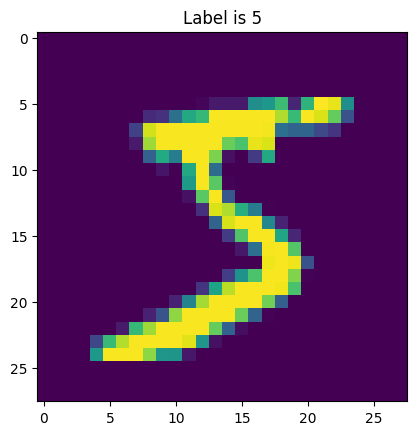

In [5]:
Image=Xtr[0,:,:]
Label=Ltr[0]


plt.title('Label is {Label}'.format(Label=Label))
plt.imshow(Image)

plt.show()
plt.close()


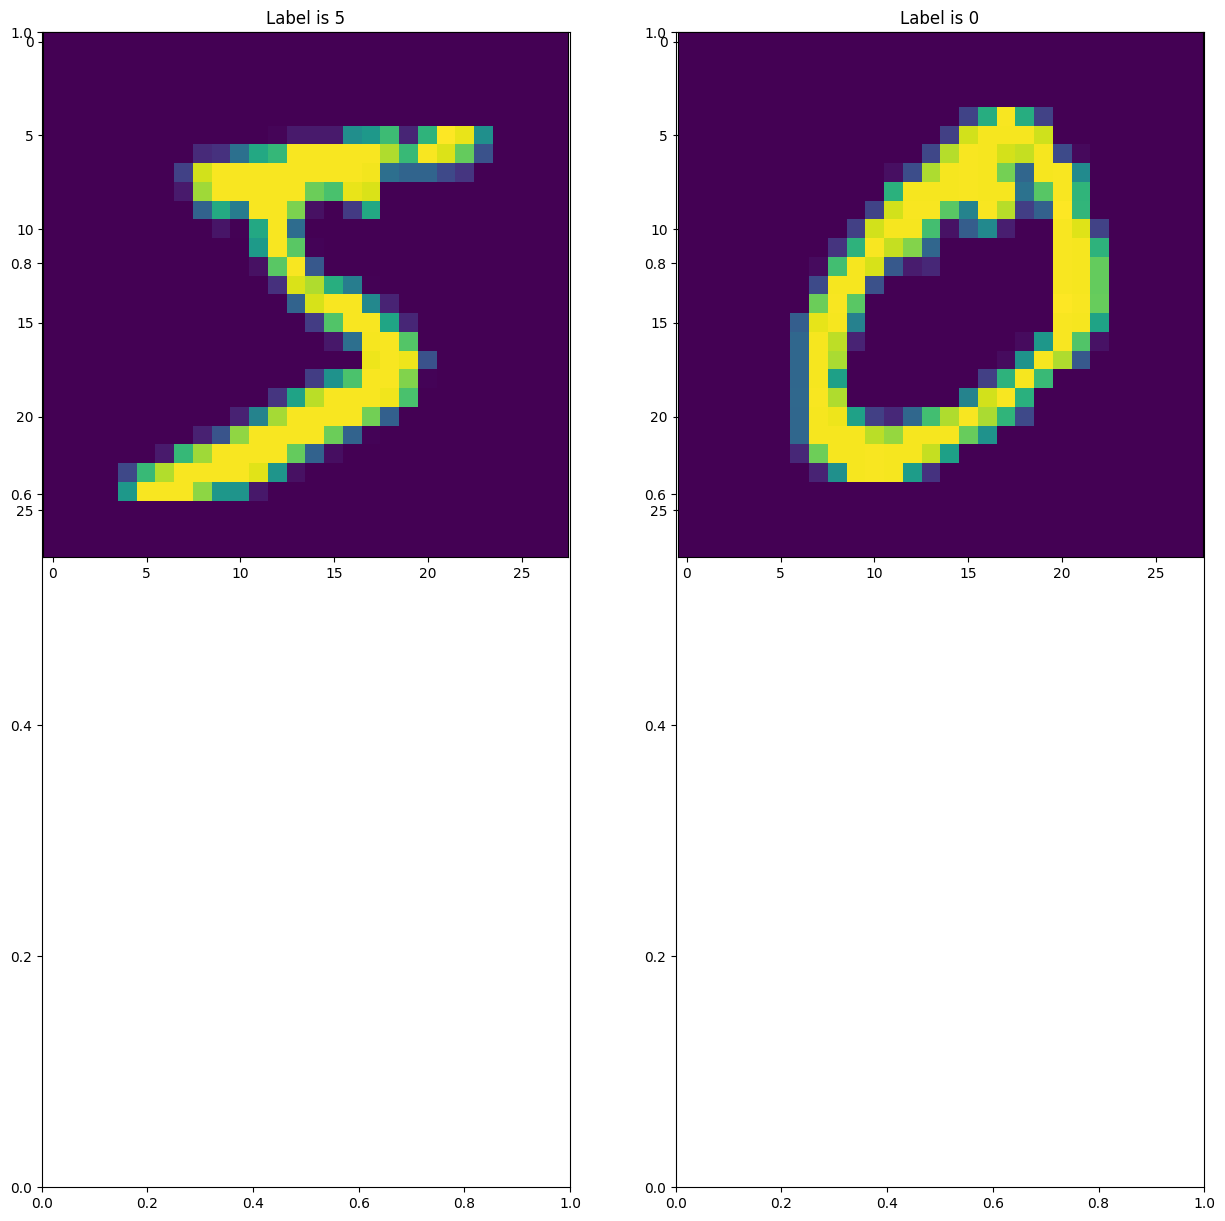

In [6]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(2,2,1)
ax1=plt.subplot(2,2,2)

Image=Xtr[0,:,:]
Label=Ltr[0]
Image1=Xtr[1,:,:]
Label1=Ltr[1]


ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(Image)
ax1.set_title('Label is {Label}'.format(Label=Label1))
ax1.imshow(Image1)


plt.show()
plt.close()


In [7]:
28*28

784

In [8]:
#Traing phase
num_sample=500
Tr_set=Xtr[:num_sample,:,:]
Ltr_set=Ltr[:num_sample]

Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2])

#Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2]).astype()
Tr_set.shape

(500, 784)

In [9]:
def predict(X):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):
        distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1)
        
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [10]:

Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=predict(Test_images)

print("Accuracy:", np.mean(Labels_predicted==L_test))



Accuracy: 0.2649


## Task 1.2

In [11]:
def get_data_for_position(data, position):
    position_data = data[position]
    
    embeddings = []
    labels = []

    for i in position_data:
        for j in position_data[i]:
            embeddings.append(j)
            labels.append(i)


    return np.array(embeddings), np.array(labels)


In [12]:
def shuffle(data, labels):
    p = np.random.permutation(len(data))
    return data[p], labels[p]

In [13]:
data = np.load('vecs.npy', allow_pickle=True).item()
data, labels = get_data_for_position(data, "1_pos")
shuffled_data, shuffled_labels = shuffle(data, labels)
print(shuffled_data)
print(shuffled_labels)


[[ -0.       -0.       -0.      ...  -0.       -0.       -0.     ]
 [ -0.       -0.       -0.      ...  -0.       -0.       -0.     ]
 [ -0.       -0.       -0.      ...  -0.       -0.       -0.     ]
 ...
 [ -0.      118.12334  -0.      ...  -0.       -0.       -0.     ]
 [ -0.       -0.       -0.      ...  -0.       -0.       -0.     ]
 [ -0.       -0.       -0.      ...  -0.       -0.       -0.     ]]
[3 4 0 ... 0 7 0]


## Task 2.1
The accuracy of the 1-NN is: `0.2649`

When running the L2 distance instead of L1 we got lower accuracy (`0.19`), when fixing the bug the value got to `0.8294` instead.

For the L1, when fixing the bug, the value changed to `0.811`.

The fixed training phase is below, the problem was that the original training set was in uint8. This meant that we had a integer overflow which caused the accuracy to be so low.

In [14]:
# Fixed training phase
num_sample=500
Tr_set=Xtr[:num_sample,:,:]
Ltr_set=Ltr[:num_sample]

# Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2])

Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2]).astype(int)
Tr_set.shape

(500, 784)

In [15]:
def new_predict(X):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):
        distances=np.sqrt(np.sum((Tr_set-X[i,:])**2,axis=1))
        
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [16]:
Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=new_predict(Test_images)

print("Accuracy:", np.mean(Labels_predicted==L_test))

Accuracy: 0.8294


In [17]:
def predict_kNN(X, k=1):
    num_test = X.shape[0]
    Lpred = np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):
        # distances = np.sum(np.square(Tr_set-X[i,:]),axis=1) # L1
        distances=np.sqrt(np.sum((Tr_set-X[i,:])**2,axis=1)) # L2
        k_indices = distances.argsort()[:k] # Get indices of k smallest distances
        k_closest_labels = Ltr_set[k_indices] # Get labels of k closest samples
        
        # Voting: Use numpy's bincount to count occurrences and get the most common label
        Lpred[i] = np.bincount(k_closest_labels).argmax()
        
    return Lpred


In [23]:
Labels_predicted_kNN = predict_kNN(Test_images, k=3) # for k=3, for example
print("k-NN Accuracy:", np.mean(Labels_predicted_kNN == L_test))

k-NN Accuracy: 0.8061


## Task 2.2

In [24]:
def predict_fold_kNN(data, values, labels, k):
    num_test= values.shape[0]
    Lpred=np.zeros(num_test, dtype=labels.dtype)
    
    for i in range(0,num_test):
        distances=np.sqrt(np.sum((data-values[i,:])**2,axis=1)) # L2
        
        k_indices = distances.argsort()[:k]
        k_closest_labels = labels[k_indices] # Get labels of k closest samples

        Lpred[i] = np.bincount(k_closest_labels).argmax()

    return Lpred

In [28]:
def three_fold_cross_validation_kNN(train, label):
    kf_folded = KFold(3)
    accuracies = defaultdict(list)

    for k in range(1,20):
        k_accuracy = []
        
        for train_index, val_index in kf_folded.split(train):
            train_data, val_data = train[train_index], train[val_index]
            label_data, label_val_data = label[train_index], label[val_index]

            predictions = predict_fold_kNN(train_data, val_data, label_data, k)
            accuracy = np.mean(predictions == label_val_data)
            #print(f"{k}: {accuracy = }")
            k_accuracy.append(accuracy)

        accuracies[k].append(np.mean(k_accuracy))

    return accuracies

In [29]:
three_fold_cross_validation_kNN(Tr_set, Ltr_set)

defaultdict(list,
            {1: [0.831998653295818],
             2: [0.7880263569247048],
             3: [0.8240386696486546],
             4: [0.8140105331505664],
             5: [0.815994516990116],
             6: [0.8040184690859244],
             7: [0.7980063968448645],
             8: [0.7980304451338287],
             9: [0.8000384772623428],
             10: [0.796058485438761],
             11: [0.7860303489406727],
             12: [0.7760382848760311],
             13: [0.7620301565543611],
             14: [0.7580621888752616],
             15: [0.7540701729071976],
             16: [0.7520380924897193],
             17: [0.7500420845056874],
             18: [0.7500541086501694],
             19: [0.7500420845056874]})

## Task 3.1


In [101]:
# Step 1: Load the Iris dataset and split it into training and test sets
iris = datasets.load_iris()
data = iris.data
target = iris.target

x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.2, train_size=0.8)

In [86]:
def test_all(x_train, y_train):
    results = {}
    kernels = ['linear', 'poly', 'rbf']
    for kernel in kernels:
        results[f"{kernel}_ovo"] = SVC(kernel = kernel, decision_function_shape = "ovo").fit(x_train, y_train)
        results[f"{kernel}_ovr"] = SVC(kernel = kernel, decision_function_shape = "ovr").fit(x_train, y_train)
    
    return results

In [87]:
def print_results(results, x_test, y_test):
    for kernel in results:
        pred = results[kernel].predict(x_test)
        disp = confusion_matrix(y_test, pred)
        print(f"{kernel = }")
        print(disp)
        print("f1 score = ", f1_score(y_test, pred, average = 'weighted'), "Accuracy =", np.mean(pred == y_test))
        print()

In [90]:
def best_acc_f1(results, x_test, y_test):
    """
    Highest combined score of f1 and accuracy. If same will return the first one.
    """
    best_kernal = ("", 0)
    for kernel in results:
        pred = results[kernel].predict(x_test)
        score = f1_score(y_test, pred, average = 'weighted') * np.mean(pred == y_test)
        if score > best_kernal[1]:
            best_kernal = (kernel, score)
    return best_kernal

In [106]:
results = test_all(x_train, y_train)
# print_results(results, x_test, y_test)
best_kernal = best_acc_f1(results, x_test, y_test)
print(f"best kernal: {best_kernal[0]} (obs can be more than one with same score)")


best kernal: linear_ovo (obs can be more than one with same score)


In [119]:
best_kernel_ovr = results["linear_ovr"]
support_vectors_per_class = {}
for class_label in np.unique(y_train):
    # Use the n_support_ attribute to find the indices of support vectors for each class
    support_indices = best_kernel_ovr.n_support_[class_label]
    support_vectors_per_class[class_label] = best_kernel_ovr.support_vectors_[support_indices]

# Display support vectors for each class
for class_label, support_vectors in support_vectors_per_class.items():
    print(f"Support vectors for class {class_label}:")
    print(support_vectors)

Support vectors for class 0:
[6.2 2.2 4.5 1.5]
Support vectors for class 1:
[6.  2.7 5.1 1.6]
Support vectors for class 2:
[5.1 2.5 3.  1.1]


In [131]:
# Step 4: Plot the decision boundary for features 2 vs. 3 and 3 vs. 4
def plot_decision_boundary(X, y, model, feature1, feature2):
    # Extract the two selected features
    X_subset = X[:, [feature1, feature2]]

    # Fit the model on the subset of features
    model.fit(X_subset, y)

    # Plot the decision boundary
    h = 0.02  # Step size in the mesh
    x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
    y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel(f"Feature {feature1+1}")
    plt.ylabel(f"Feature {feature2+1}")
    plt.show()


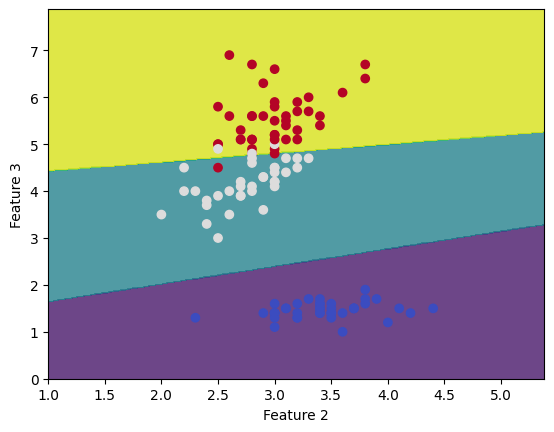

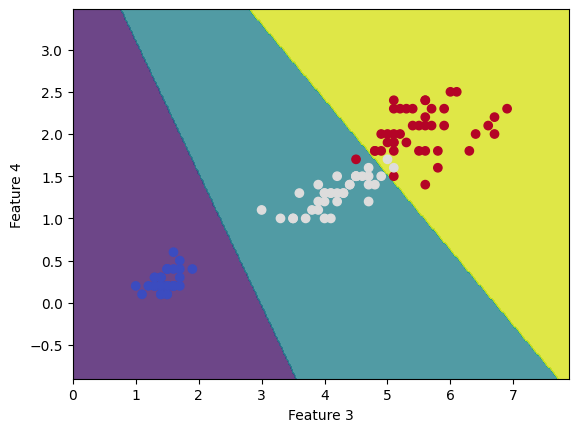

In [140]:
# 0-indexed
plot_decision_boundary(x_train, y_train, best_kernel_ovr, 1, 2)
plot_decision_boundary(x_train, y_train, best_kernel_ovr, 2, 3)